## Image classification with Convolutional Neural Networks

## Modification of L1 Dogs vs Cats to solve dog breeds challenge: https://www.kaggle.com/c/dog-breed-identification/data

We're going to try to create a model to enter the Dogs vs Cats competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if we can beat 80%, then we will be at the cutting edge as of 2013!

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.torch_imports import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [5]:
PATH = "/root/notebooks/data_small/dog-breed-identification"
TRAIN_PATH = os.path.join(PATH, 'train')
CSV_TRAIN_PATH = os.path.join(PATH, 'labels.csv')
sz=224
!ls {PATH} #My data that is cached to blobby
print(TRAIN_PATH)
print(CSV_TRAIN_PATH)

labels.csv  models  sample_submission.csv  test  tmp  train
/root/notebooks/data_small/dog-breed-identification/train
/root/notebooks/data_small/dog-breed-identification/labels.csv


In [6]:
n = len(list(open(CSV_TRAIN_PATH))) - 1
val_idxs = get_cv_idxs(n) # This automatically subsamples off a validation set, ~20% of the data

In [7]:
print(n)
print(len(val_idxs))
print(2044/10222)

10222
2044
0.19996086871453728


It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [8]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [9]:
torch.backends.cudnn.enabled

True

### Extra steps if NOT using Crestle or Paperspace or our scripts

The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. `wget http://files.fast.ai/data/dogscats.zip`. You should put the data in a subdirectory of this notebook's directory, called `data/`. Note that this data is already available in Crestle and the Paperspace fast.ai template.

### Extra steps if using Crestle

Crestle has the datasets required for fast.ai in /datasets, so we'll create symlinks to the data we want for this competition. (NB: we can't write to /datasets, but we need a place to store temporary files, so we create our own writable directory to put the symlinks in, and we also take advantage of Crestle's `/cache/` faster temporary storage space.)

To run these commands (**which you should only do if using Crestle**) remove the `#` characters from the start of each line.

In [17]:
# os.makedirs('data/dogscats/models', exist_ok=True)

# !ln -s /datasets/fast.ai/dogscats/train {PATH}
# !ln -s /datasets/fast.ai/dogscats/test {PATH}
# !ln -s /datasets/fast.ai/dogscats/valid {PATH}

# os.makedirs('/cache/tmp', exist_ok=True)
# !ln -fs /cache/tmp {PATH}

In [18]:
# os.makedirs('/cache/tmp', exist_ok=True)
# !ln -fs /cache/tmp {PATH}

## First look at some dog breed pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [19]:
os.listdir(PATH)

['train', 'labels.csv', 'test', 'sample_submission.csv']

In [31]:
files = os.listdir(f'{PATH}/train')[:5]
files

['d6fbd70900969f939deaa4f101408858.jpg',
 'd8213d9a6c78738f4136606db0b88362.jpg',
 'e8e9ea1506e0ad9382665b2690ecb4e9.jpg',
 '80530662979f925e5854d840ac73418b.jpg',
 'f6c6e52ad7508381c9b545e7e4f77d8d.jpg']

In [43]:
# Load csv into pandas
import pandas as pd
df = pd.read_csv(f'{PATH}/labels.csv')

In [89]:
df

id                        breed
0      000bec180eb18c7604dcecc8fe0dba07                  boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                        dingo
2      001cdf01b096e06d78e9e5112d419397                     pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                     bluetick
4      0021f9ceb3235effd7fcde7f7538ed62             golden_retriever
5      002211c81b498ef88e1b40b9abf84e1d           bedlington_terrier
6      00290d3e1fdd27226ba27a8ce248ce85           bedlington_terrier
7      002a283a315af96eaea0e28e7163b21b                       borzoi
8      003df8b8a8b05244b1d920bb6cf451f9                      basenji
9      0042188c895a2f14ef64a918ed9c7b64           scottish_deerhound
10     004396df1acd0f1247b740ca2b14616e            shetland_sheepdog
11     0067dc3eab0b3c3ef0439477624d85d6                 walker_hound
12     00693b8bc2470375cc744a6391d397ec                  maltese_dog
13     006cc3ddb9dc1bd827479569fcdc52dc                     bluetick
14     0075dc49dab4024d12fafe67074d8a81              norfolk_terrier
15     00792e341f3c6eb33663e415d0715370          african_hunting_dog
16     007b5a16db9d9ff9d7ad39982703e429      wire-haired_fox_terrier
17     007b8a07882822475a4ce6581e70b1f8                      redbone
18     007ff9a78eba2aebb558afea3a51c469             lakeland_terrier
19     008887054b18ba3c7601792b6a453cc3                        boxer
20     008b1271ed1addaccf93783b39deab45                     doberman
21     008ba178d6dfc1a583617470d19c1673                   otterhound
22     009509be3ca7cce0ff9e37c8b09b1125                   otterhound
23     0097c6242c6f3071762d9f85c3ef1b2f           bedlington_terrier
24     00a338a92e4e7bf543340dc849230e75                        dingo
25     00a366d4b4a9bbb6c8a63126697b7656             golden_retriever
26     00a862390341c5be090dd72bd2bc19ef           standard_schnauzer
27     00b7d114bc5166a629a3cc03d9329120          irish_water_spaniel
28     00ba244566e36e0af3d979320fd3017f      black-and-tan_coonhound
29     00bee065dcec471f26394855c5c2f3de                        cairn
...                                 ...                          ...
10192  ff4afeb51a1473f7ba18669a8ff48bc9               border_terrier
10193  ff4bb57ce419cd637dd511a1b5474bff                  appenzeller
10194  ff52a3909f5801a71161cec95d213107  west_highland_white_terrier
10195  ff54d45962b3123bb67052e8e29a60e7                      basenji
10196  ff63ed894f068da8e2bbdfda50a9a9f8                        boxer
10197  ff63fa05a58473138848f80840064d23                affenpinscher
10198  ff6f47aa8e181b6efa4d0be7b09b5628             golden_retriever
10199  ff7334b06cee8667a7f30eb00e0b93cf                      whippet
10200  ff7d9c08091acc3b18b869951feeb013                  maltese_dog
10201  ff84992beff3edd99b72718bec9448d2           bedlington_terrier
10202  ff8e3fa7e04faca99af85195507ee54d             sealyham_terrier
10203  ff91c3c095a50d3d7f1ab52b60e93638                affenpinscher
10204  ffa0055ec324829882186bae29491645                  maltese_dog
10205  ffa0ad682c6670db3defce2575a2587f             english_springer
10206  ffa16727a9ee462ee3f386be865b199e              irish_wolfhound
10207  ffa4e1bf959425bad9228b04af40ac76                      basenji
10208  ffa6a8d29ce57eb760d0f182abada4bf             english_foxhound
10209  ffbbf7536ba86dcef3f360bda41181b4                   weimaraner
10210  ffc1717fc5b5f7a6c76d0e4ea7c8f93a                   great_dane
10211  ffc2b6b9133a6413c4a013cff29f9ed2                 irish_setter
10212  ffc532991d3cd7880d27a449ed1c4770              tibetan_terrier
10213  ffca1c97cea5fada05b8646998a5b788             english_foxhound
10214  ffcb610e811817766085054616551f9c                       briard
10215  ffcde16e7da0872c357fbc7e2168c05f                     airedale
10216  ffcffab7e4beef9a9b8076ef2ca51909                      samoyed
10217  ffd25009d635cfd16e793503ac5edef0                       borzoi
10218  ffd3f636f7f379c51ba3648a9ff8

In [53]:
df.size

20444

In [66]:
df.loc

id       001513dfcb2ffafc82cccf4d8bbaba97
breed                               dingo
Name: 1, dtype: object

In [80]:
df.loc[0][0]

'000bec180eb18c7604dcecc8fe0dba07'

In [81]:
df.loc[0][1]

'boston_bull'

In [90]:
df.loc[df['id']=='000bec180eb18c7604dcecc8fe0dba07']

id        breed
0  000bec180eb18c7604dcecc8fe0dba07  boston_bull

In [101]:
df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [106]:
df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=True)

id
breed                              
briard                           66
eskimo_dog                       66
komondor                         67
brabancon_griffon                67
golden_retriever                 67
german_shepherd                  69
walker_hound                     69
giant_schnauzer                  69
tibetan_mastiff                  69
otterhound                       69
vizsla                           70
french_bulldog                   70
soft-coated_wheaten_terrier      71
chihuahua                        71
kuvasz                           71
standard_schnauzer               72
border_collie                    72
flat-coated_retriever            72
curly-coated_retriever           72
redbone                          72
malinois                         73
brittany_spaniel                 73
cocker_spaniel                   74
doberman                         74
american_staffordshire_terrier   74
english_springer                 75
pekinese                         75
borzoi                           75
bull_mastiff                     75
boxer                            75
...                             ...
pembroke                         92
italian_greyhound                92
chow                             93
pug                              94
norwegian_elkhound               95
whippet                          95
siberian_husky                   95
papillon                         96
saluki                           99
lakeland_terrier                 99
irish_wolfhound                 101
miniature_pinscher              102
blenheim_spaniel                102
australian_terrier              102
japanese_spaniel                105
beagle                          105
cairn                           106
leonberg                        106
tibetan_terrier                 107
airedale                        107
samoyed                         109
basenji                         110
pomeranian                      111
great_pyrenees                  111
shih-tzu                        112
bernese_mountain_dog            114
entlebucher                     115
afghan_hound                    116
maltese_dog                     117
scottish_deerhound              126

[120 rows x 1 columns]

In [94]:
def explore_image(img_path, df):
    img = plt.imread(img_path)
    plt.imshow(img);
    print(df.loc[df['id'] == img_path.split('/')[-1].split('.jpg')[0]])

                                    id   breed
8563  d6fbd70900969f939deaa4f101408858  basset


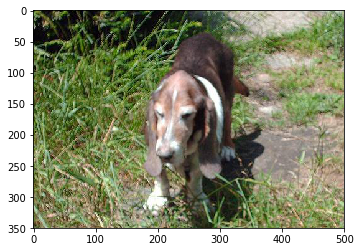

In [96]:
explore_image(f'{PATH}/train/{files[0]}', df)

                                    id       breed
8604  d8213d9a6c78738f4136606db0b88362  weimaraner


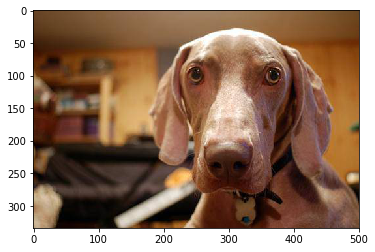

In [97]:
explore_image(f'{PATH}/train/{files[1]}', df)

                                    id      breed
9277  e8e9ea1506e0ad9382665b2690ecb4e9  chihuahua


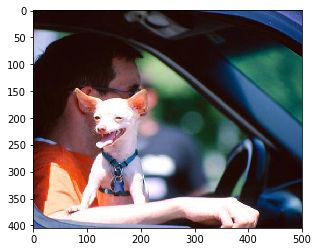

In [98]:
explore_image(f'{PATH}/train/{files[2]}', df)

Here is how the raw data looks like

In [99]:
img.shape

(350, 500, 3)

In [100]:
img[:4,:4]

array([[[ 65,  91,  43],
        [ 34,  59,   4],
        [ 24,  46,   0],
        [ 94, 112,  38]],

       [[ 59,  87,  36],
        [ 56,  84,  26],
        [ 62,  84,  20],
        [109, 130,  55]],

       [[ 55,  86,  29],
        [ 66,  96,  36],
        [ 79, 106,  39],
        [111, 133,  58]],

       [[ 84, 119,  55],
        [ 80, 112,  47],
        [ 84, 114,  44],
        [110, 137,  60]]], dtype=uint8)

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [6]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [16]:
arch=resnet34
data = ImageClassifierData.from_csv(PATH, 'train', CSV_TRAIN_PATH, tfms=tfms_from_model(arch, sz), suffix='.jpg')
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [17]:
learn.fit(0.01, 2)

# epoch      trn_loss   val_loss   accuracy                   
#     0      2.15382    1.0155     0.776908  
#     1      1.080223   0.678412   0.819961

epoch      trn_loss   val_loss   accuracy                   
    0      2.101563   1.003782   0.776419  
    1      1.067723   0.68222    0.815558                   



[array([0.68222]), 0.8155577297080053]

In [18]:
# Above default resnet34 got 81% accuracy, try resnext101_64
# Note, have to put weights into fastai directory for this to work

arch=resnext101_64
sz = 224
bs = 58

data = ImageClassifierData.from_csv(PATH, 'train', CSV_TRAIN_PATH, tfms=tfms_from_model(arch, sz), suffix='.jpg')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

# epoch      trn_loss   val_loss   accuracy                    
#     0      0.942279   0.360754   0.913894  
#     1      0.432821   0.291003   0.920744

epoch      trn_loss   val_loss   accuracy                    
    0      0.952932   0.374814   0.909002  
    1      0.442904   0.290981   0.911448                    



[array([0.29098]), 0.9114481405502662]

In [19]:
# Now with new transforms

arch=resnext101_64
sz = 224
bs = 58
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

data = ImageClassifierData.from_csv(PATH, 'train', CSV_TRAIN_PATH, test_name='test', bs=bs, 
                                    tfms=tfms, suffix='.jpg', val_idxs=val_idxs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

# epoch      trn_loss   val_loss   accuracy                    
#     0      0.913256   0.370239   0.915362  
#     1      0.416469   0.281041   0.924168 

epoch      trn_loss   val_loss   accuracy                    
    0      0.893973   0.369923   0.912916  
    1      0.408317   0.273672   0.926125                    



[array([0.27367]), 0.926125249809015]

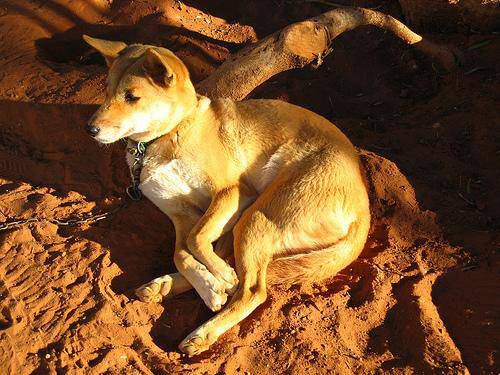

In [131]:
fn = os.path.join(PATH,data.trn_ds.fnames[0])
PIL.Image.open(fn)

In [135]:
size_d = {k: PIL.Image.open(os.path.join(PATH,k)).size for k in data.trn_ds.fnames}

In [136]:
size_d

{'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg': (500, 375),
 'train/001cdf01b096e06d78e9e5112d419397.jpg': (500, 375),
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg': (500, 500),
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg': (500, 375),
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg': (500, 470),
 'train/002a283a315af96eaea0e28e7163b21b.jpg': (231, 227),
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg': (500, 332),
 'train/0067dc3eab0b3c3ef0439477624d85d6.jpg': (402, 343),
 'train/006cc3ddb9dc1bd827479569fcdc52dc.jpg': (250, 223),
 'train/00792e341f3c6eb33663e415d0715370.jpg': (200, 192),
 'train/007b5a16db9d9ff9d7ad39982703e429.jpg': (374, 212),
 'train/007b8a07882822475a4ce6581e70b1f8.jpg': (333, 500),
 'train/007ff9a78eba2aebb558afea3a51c469.jpg': (500, 375),
 'train/008ba178d6dfc1a583617470d19c1673.jpg': (390, 320),
 'train/009509be3ca7cce0ff9e37c8b09b1125.jpg': (400, 346),
 'train/00a338a92e4e7bf543340dc849230e75.jpg': (200, 280),
 'train/00a366d4b4a9bbb6c8a63126697b7656.jpg': (500, 375

In [148]:
row_sz, col_sz = list(zip(*size_d.values()))

In [150]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

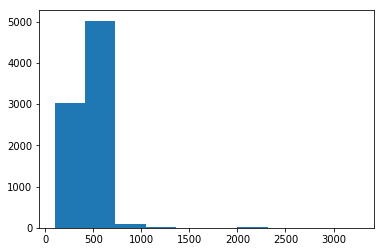

In [153]:
plt.hist(row_sz)

(array([2870., 5121.,  128.,   25.,   10.,   15.,    5.,    2.,    0.,    2.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

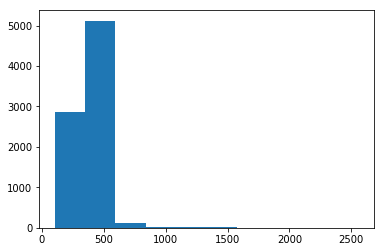

In [154]:
plt.hist(col_sz)

(array([  64.,  377.,  392., 1104., 1105.,  376., 4438.,   99.,   73.,   23.]),
 array([ 97. , 161.8, 226.6, 291.4, 356.2, 421. , 485.8, 550.6, 615.4, 680.2, 745. ]),
 <a list of 10 Patch objects>)

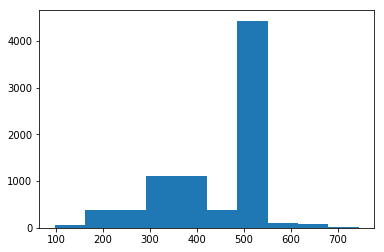

In [158]:
plt.hist(row_sz[row_sz<750])

(array([ 118.,  448.,  550., 1921., 2883.,  420., 1631.,   78.,   29.,    9.]),
 array([102. , 166.1, 230.2, 294.3, 358.4, 422.5, 486.6, 550.7, 614.8, 678.9, 743. ]),
 <a list of 10 Patch objects>)

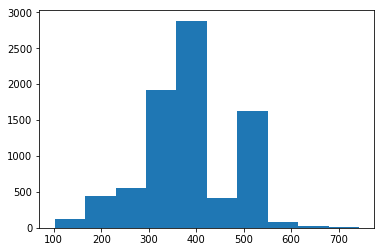

In [159]:
plt.hist(col_sz[col_sz<750])

## Resizing
Based on histogram, seems we should resize things above 300 (image net was trained on 240~)

In [162]:
arch=resnext101_64
sz = 224
bs = 58

In [23]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

    data = ImageClassifierData.from_csv(PATH, 'train', CSV_TRAIN_PATH, test_name='test', bs=bs, 
                                        tfms=tfms, suffix='.jpg', val_idxs=val_idxs)
    return data if sz>300 else data.resize(340,'tmp')

In [318]:
sz, bs = 256, 50 # if cuda crash / memory error, reduce batch size (half it)
data = get_data(sz, bs)

In [166]:
%time learn = ConvLearner.pretrained(arch, data, precompute=True)
%time learn.fit(1e-2, 5)

                                                      
100%|██████████| 208/208 [00:23<00:00,  8.74it/s]


epoch      trn_loss   val_loss   accuracy                   
    0      2.959279   2.493238   0.385519  
    1      2.33959    2.357154   0.405577                   
    2      2.071074   2.324704   0.415851                   
    3      1.873923   2.330045   0.417319                   
    4      1.722489   2.358098   0.416341                   



[array([2.3581]), 0.41634050857297594]

In [319]:
sz, bs = 224, 64 # if cuda crash / memory error, reduce batch size (half it)
data = get_data(sz, bs)
%time learn = ConvLearner.pretrained(arch, data, precompute=True)
%time learn.fit(1e-2, 5)

# 100%|██████████| 128/128 [00:52<00:00,  2.44it/s]
# 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
# 100%|██████████| 162/162 [01:06<00:00,  2.42it/s]
# CPU times: user 4min 29s, sys: 30.8 s, total: 5min
# Wall time: 2min 14s
# Epoch
# 100% 5/5 [00:13<00:00, 2.69s/it]
# epoch      trn_loss   val_loss   accuracy                   
#     0      1.020385   0.413381   0.900685  
#     1      0.480265   0.312156   0.915362                    
#     2      0.317149   0.289808   0.914384                    
#     3      0.241271   0.267535   0.910959                    
#     4      0.201246   0.265298   0.915362                    

# CPU times: user 13.7 s, sys: 6.62 s, total: 20.3 s
# Wall time: 13.5 s

CPU times: user 1.22 s, sys: 368 ms, total: 1.59 s
Wall time: 1.6 s


epoch      trn_loss   val_loss   accuracy                    
    0      0.987456   0.39863    0.901174  
    1      0.451609   0.306571   0.90998                     
    2      0.299935   0.27956    0.915362                    
    3      0.241785   0.257373   0.921233                    
    4      0.185286   0.252802   0.918297                    
CPU times: user 12.4 s, sys: 6.88 s, total: 19.3 s
Wall time: 12.6 s


[array([0.2528]), 0.9182974556187594]

In [20]:
learn.save('dogbreeds_224_pre')
# saves to /root/notebooks/data_small/dog-breed-identification/tmp/340/models/dogbreeds_224_pre.h5

In [21]:
learn.load('dogbreeds_224_pre')

### Increasing the size to additionally train on the same network
"This is an amazing technique, commonly used for huge gains" -- err isn't this the same thing as zooming? - maybe zooming crops part of the image?

note: vgg doesn't support arbitrary sizes. Modern fully convolutional architectures like resnext do

In [176]:
%time learn.set_data(get_data(299, bs))
%time learn.freeze()


CPU times: user 492 ms, sys: 24 ms, total: 516 ms
Wall time: 512 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 367 µs


In [177]:
%time learn.fit(1e-2, 3, cycle_len=1)
get
# CPU times: user 7.88 s, sys: 3.96 s, total: 11.8 s
# Wall time: 7.73 s
# [array([0.25372]), 0.9222113507601146]

epoch      trn_loss   val_loss   accuracy                    
    0      0.151018   0.254436   0.920744  
    1      0.142268   0.247788   0.919765                    
    2      0.131371   0.253719   0.922211                    

CPU times: user 7.88 s, sys: 3.96 s, total: 11.8 s
Wall time: 7.73 s


[array([0.25372]), 0.9222113507601146]

In [178]:
learn.set_data(get_data(400, bs))
learn.freeze()
%time learn.fit(1e-2, 3, cycle_len=1)

# epoch      trn_loss   val_loss   accuracy                    
#     0      0.122001   0.249602   0.918297  
#     1      0.116757   0.251079   0.919765                    
#     2      0.106679   0.252989   0.919276                    

# CPU times: user 7.52 s, sys: 4.23 s, total: 11.8 s
# Wall time: 7.75 s

epoch      trn_loss   val_loss   accuracy                    
    0      0.122001   0.249602   0.918297  
    1      0.116757   0.251079   0.919765                    
    2      0.106679   0.252989   0.919276                    

CPU times: user 7.52 s, sys: 4.23 s, total: 11.8 s
Wall time: 7.75 s


[array([0.25299]), 0.9192759287334001]

In [179]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.099781   0.253438   0.918297  
    1      0.096032   0.24979    0.920254                     
    2      0.08085    0.246867   0.919765                     
    3      0.091725   0.243667   0.923679                     
    4      0.078198   0.243408   0.923679                     
    5      0.070304   0.242498   0.923679                     
    6      0.066173   0.240099   0.92319                      

CPU times: user 18.5 s, sys: 9.71 s, total: 28.2 s
Wall time: 18.9 s


[array([0.2401]), 0.9231898235248259]

In [214]:
%time log_preds, y = learn.TTA()

CPU times: user 2.01 s, sys: 1.23 s, total: 3.24 s
Wall time: 2.09 s


In [219]:
probs = np.mean(np.exp(log_preds), axis=0)
preds = np.mean(np.exp(log_preds),0)

In [216]:
# tensor_preds = torch.from_numpy(log_preds)
# tensor_y = torch.from_numpy(y)
# accuracy(tensor_preds, tensor_y), metrics.log_logg(y, probs) # still doesn't work
# help - http://forums.fast.ai/t/lesson-2-dog-breeds-error-on-call-of-accuracy-log-preds-y/11965/5

In [221]:
accuracy_np(preds, y), metrics.log_loss(y, probs)
# not sure that this is right. Seems ballpark okay

(0.9231898238747553, 0.24031627420551513)

## Learn a few more times

Looks like the training loss is much less than validation loss, try on smaller pics

In [298]:
learn.set_data(get_data(128, bs))
learn.freeze()
%time learn.fit(1e-2, 3, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.096929   1.163624   0.786693  
    1      1.003944   1.134056   0.785225                   
    2      0.947681   1.076065   0.785714                    
    3      0.866586   1.026881   0.786204                    
    4      0.818993   1.010516   0.789628                    
    5      0.789429   1.001602   0.791096                    
    6      0.763855   0.949176   0.790607                    
    7      0.732134   0.914551   0.792074                    
    8      0.673438   0.893992   0.793053                    
    9      0.656782   0.877658   0.794031                    
    10     0.666318   0.861449   0.78865                     
    11     0.621424   0.863473   0.793542                    
    12     0.632182   0.852989   0.790607                    
    13     0.659984   0.857415   0.791096                    
CPU times: user 20min 52s, sys: 1min 26s, total: 22min 18s
Wall time: 6min 28s


[array([0.85741]), 0.7910958902943158]

Overfitting bigtime boys. What to do now...??

    11     0.035716   0.252526   0.921722                     
    12     0.037763   0.252041   0.924168                     
    13     0.039976   0.258837   0.921722 

In [299]:
lrf=learn.lr_find()

 93%|█████████▎| 119/128 [00:19<00:01,  5.97it/s, loss=2.51] 

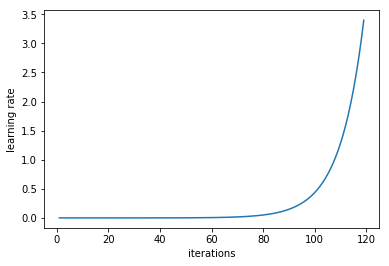

In [300]:
learn.sched.plot_lr()

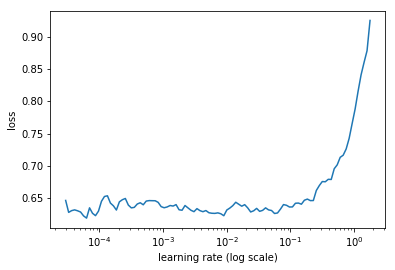

In [301]:
learn.sched.plot()

Okay maybe the learning rate was too high, going to train on a lower rate

In [229]:
learn.freeze()
%time learn.fit(2e-2, 3, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.03433    0.358798   0.914384  
    1      0.033413   0.376137   0.913894                     
    2      0.032083   0.367483   0.916341                     
    3      0.02691    0.36074    0.916341                     
    4      0.027411   0.364895   0.911448                     
    5      0.027057   0.363681   0.912916                     
    6      0.027342   0.366413   0.915362                     
    7      0.026577   0.365094   0.915851                     
    8      0.023338   0.360212   0.915362                     
    9      0.023449   0.362484   0.917808                     
    10     0.019018   0.365091   0.916341                     
    11     0.021014   0.358726   0.915362                     
    12     0.017636   0.367045   0.914873                     
    13     0.026926   0.361723   0.916341                     

CPU times: user 34.5 s, sys: 19.6 s, total: 54 s
Wall time: 35.4 s


[array([0.36172]), 0.9163405079897603]

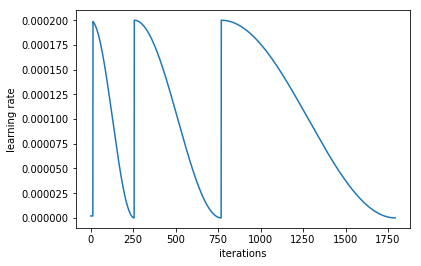

In [227]:
learn.sched.plot_lr()

Still overfitting like a god damn goose. Okay not sure how to reverse... dropout?

    11     0.021014   0.358726   0.915362                     
    12     0.017636   0.367045   0.914873                     
    13     0.026926   0.361723   0.916341 

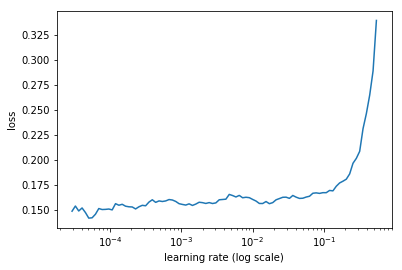

In [320]:
lrf=learn.lr_find()
learn.sched.plot()

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [234]:
# This is the label for a val data
data.val_y

array([ 19,  15,   7, ..., 109,   3,  28])

In [235]:
# All the dog classes
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [306]:
data.classes.index('pomeranian')

87

In [305]:
data.classes[87]

'pomeranian'

In [237]:
len(data.classes)

120

In [236]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2044, 120)

In [243]:
log_preds[0][:10]

array([-28.16237, -32.37303, -27.6526 , -28.08195, -28.89776, -28.23681, -30.43877, -24.51212, -22.78458,
       -28.47729], dtype=float32)

In [244]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [245]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [246]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [218]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [250]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(os.path.join(PATH, ds.fnames[idx])))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


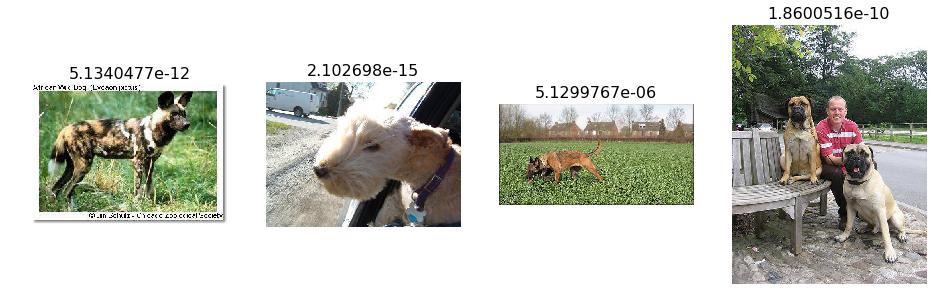

In [251]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


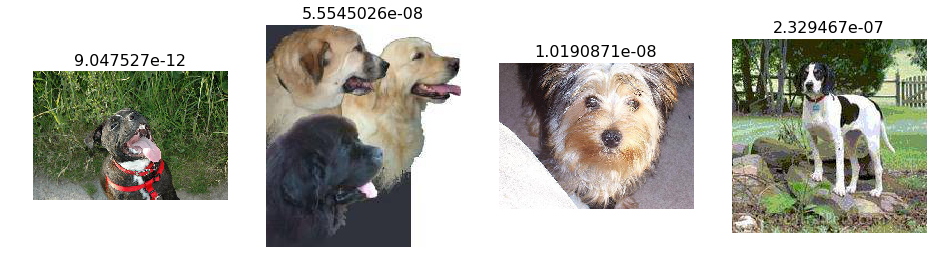

In [252]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [253]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct afghan_hound


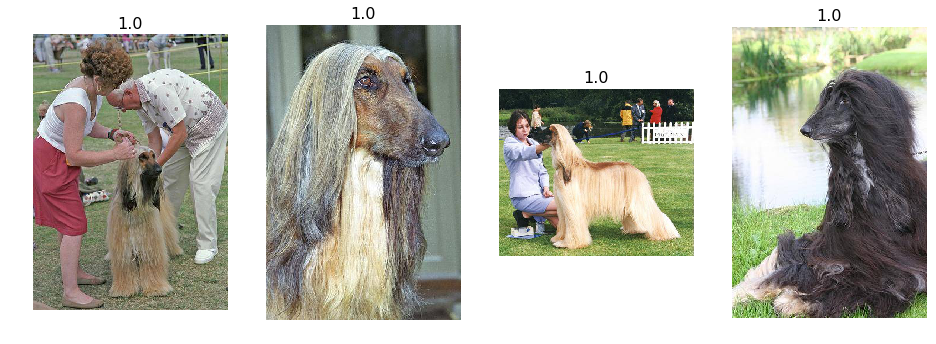

In [270]:
class_num = 1
plot_val_with_title(most_by_correct(class_num, True), f"Most correct {data.classes[class_num]}")

Most correct english_setter


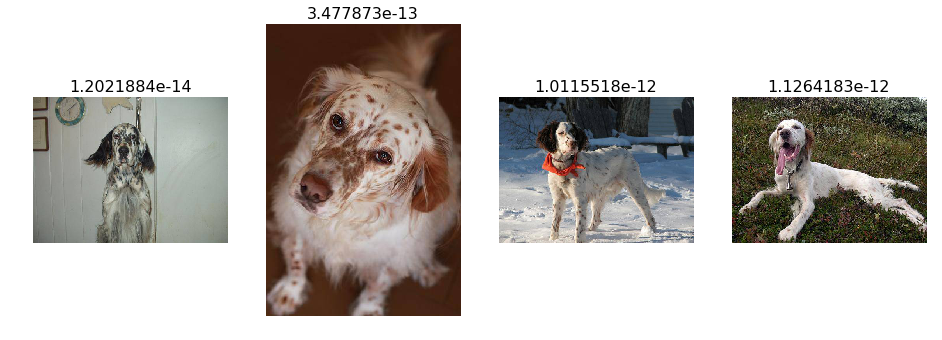

In [277]:
class_num = 40
plot_val_with_title(most_by_correct(class_num, True), f"Most correct {data.classes[class_num]}")

Most correct norwegian_elkhound


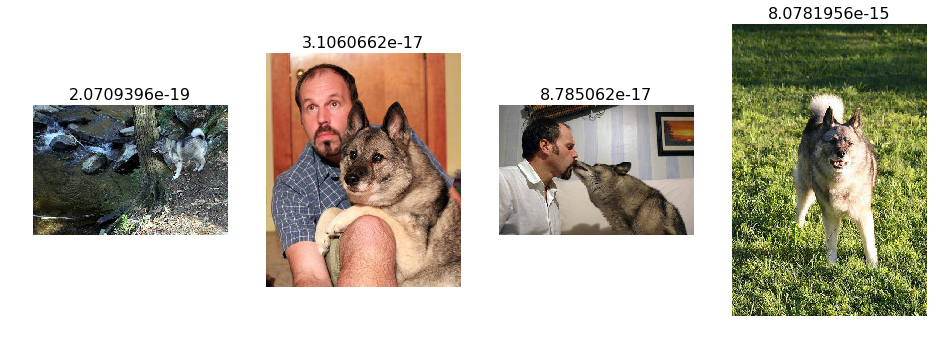

In [278]:
class_num = 80
plot_val_with_title(most_by_correct(class_num, True), f"Most correct {data.classes[class_num]}")

Most correct yorkshire_terrier


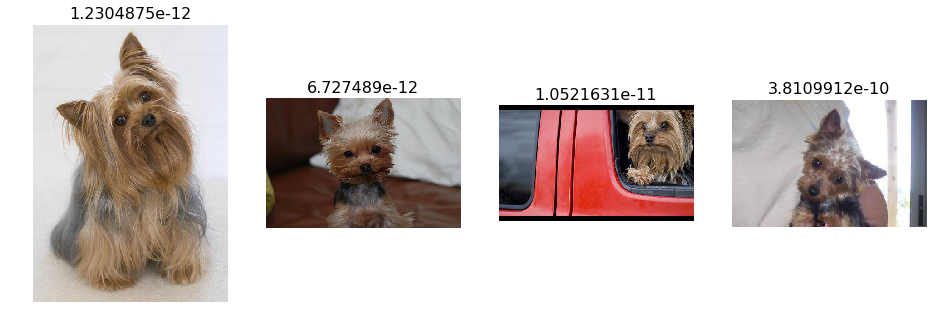

In [279]:
class_num = 119
plot_val_with_title(most_by_correct(class_num, True), f"Most correct {data.classes[class_num]}")

Most correct pomeranian


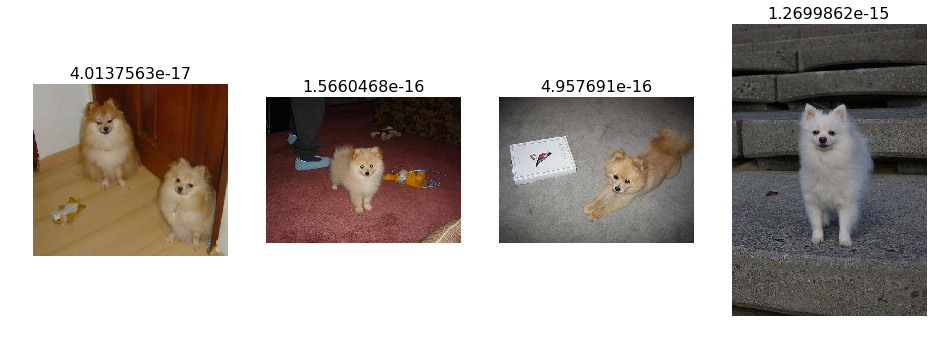

In [307]:
class_num = 87
plot_val_with_title(most_by_correct(class_num, True), f"Most correct {data.classes[class_num]}")

Most uncertain predictions


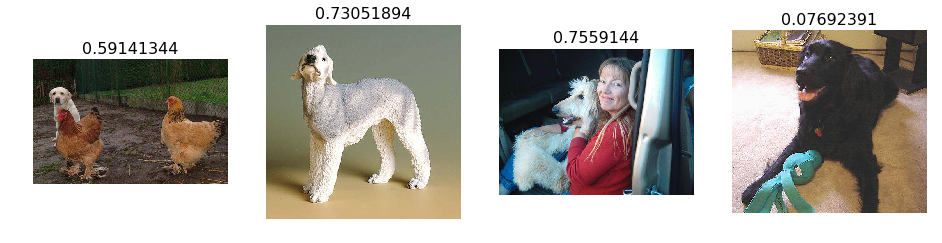

In [310]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

Most uncertain predictions


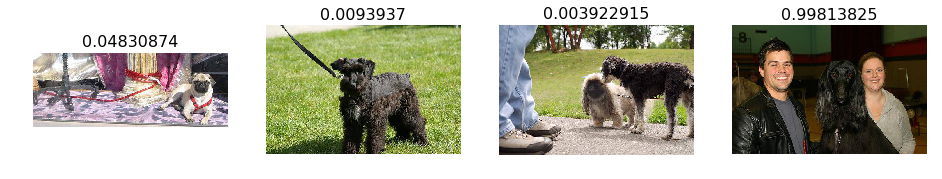

In [309]:
most_uncertain = np.argsort(np.abs(probs -0.5))[4:8]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Improving our model past data augmentation

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [24]:
learn.set_data(get_data(299, bs))
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [25]:
# Split to about first ~50 layers, ~50 middle layers, and the last fully connected layers
lr=np.array([1e-5,1e-4,1e-3]) 

In [26]:
%time learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.432725   0.297555   0.920744  
    1      0.418366   0.289851   0.922211                    
    2      0.389299   0.289258   0.921233                    



[array([0.28926]), 0.9212328742045013]

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

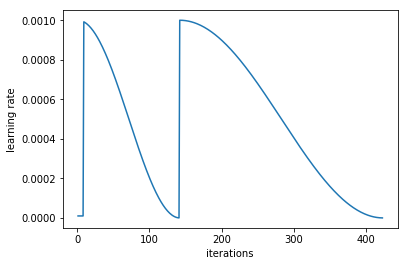

In [27]:
learn.sched.plot_lr()

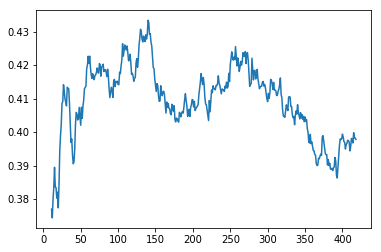

In [28]:
learn.sched.plot_loss()

In [29]:
sz

224

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [32]:
learn.save('dogbreeds_229_all')

In [33]:
learn.load('dogbreeds_229_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [34]:
%time log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [36]:
%time accuracy_np(probs, y)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 816 µs


0.9261252446183953

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [37]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[20  0  0 ...  0  0  0]
 [ 0 22  0 ...  0  0  0]
 [ 0  0 26 ...  0  0  0]
 ...
 [ 0  0  0 ... 14  0  0]
 [ 0  0  0 ...  0 14  0]
 [ 0  0  0 ...  0  0 16]]
CPU times: user 6.46 s, sys: 492 ms, total: 6.95 s
Wall time: 6.57 s


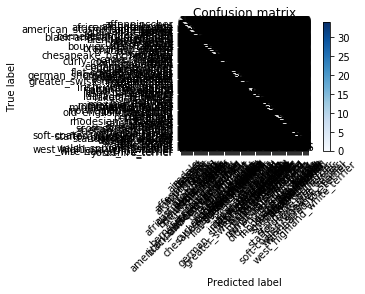

In [40]:
%time plot_confusion_matrix(cm, data.classes)

# Submitting results to Kaggle
with most up to date 92% model, with TTA

In [48]:
%time test_log_preds, test_y = learn.TTA(is_test=True) #is_test = True automagically runs on the test folder

CPU times: user 20min 50s, sys: 2min 30s, total: 23min 21s
Wall time: 10min 1s


In [54]:
%time test_probs = np.mean(np.exp(test_log_preds),0) # average across the 5 TTA's

CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 92.5 ms


In [55]:
%time test_probs_method2 = np.exp(test_log_preds[0]) # Don't average, just use the first of the TTA

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 17.9 ms


In [70]:
np.exp(test_log_preds).shape

(5, 10357, 120)

In [56]:
test_probs.shape

(10357, 120)

In [57]:
test_probs_method2.shape

(10357, 120)

In [62]:
test_probs[0]

array([0.0054 , 0.00223, 0.00055, 0.00043, 0.00008, 0.00028, 0.00157, 0.00021, 0.00118, 0.00021, 0.00133,
       0.00234, 0.00426, 0.00418, 0.0007 , 0.00052, 0.00012, 0.00073, 0.00032, 0.00021, 0.02613, 0.0001 ,
       0.00036, 0.00316, 0.00026, 0.00018, 0.00069, 0.0002 , 0.00006, 0.00076, 0.00049, 0.00035, 0.01122,
       0.00012, 0.00925, 0.0041 , 0.00061, 0.00006, 0.00024, 0.00032, 0.00189, 0.00167, 0.00024, 0.0001 ,
       0.00079, 0.00051, 0.00017, 0.00109, 0.01387, 0.00019, 0.0056 , 0.00146, 0.00032, 0.00019, 0.0001 ,
       0.0001 , 0.0011 , 0.0029 , 0.20691, 0.00031, 0.00045, 0.00111, 0.00099, 0.0001 , 0.09084, 0.00042,
       0.00085, 0.00019, 0.00181, 0.00008, 0.00151, 0.00091, 0.00012, 0.00262, 0.00076, 0.00189, 0.14034,
       0.00255, 0.00107, 0.00159, 0.00065, 0.00159, 0.00224, 0.00551, 0.00106, 0.00039, 0.00114, 0.00125,
       0.0009 , 0.00015, 0.0001 , 0.00105, 0.00008, 0.00073, 0.00038, 0.00044, 0.0167 , 0.0003 , 0.00429,
       0.00037, 0.00154, 0.00064, 0.00187, 0.0

In [63]:
test_probs_method2[0]

array([0.00272, 0.00177, 0.00042, 0.00033, 0.00003, 0.00007, 0.00085, 0.00013, 0.00066, 0.00018, 0.00102,
       0.00209, 0.00239, 0.0034 , 0.00059, 0.00031, 0.00009, 0.00028, 0.00017, 0.00017, 0.01222, 0.00006,
       0.00012, 0.00225, 0.00024, 0.00013, 0.00029, 0.00008, 0.00007, 0.00048, 0.00027, 0.00021, 0.00801,
       0.00015, 0.01322, 0.00307, 0.00036, 0.00004, 0.00011, 0.00027, 0.00244, 0.00107, 0.00009, 0.00006,
       0.00042, 0.00032, 0.0001 , 0.00096, 0.0056 , 0.00018, 0.00354, 0.00106, 0.0002 , 0.0001 , 0.00004,
       0.00008, 0.0015 , 0.0019 , 0.14887, 0.00034, 0.00044, 0.00075, 0.00085, 0.00005, 0.0225 , 0.00041,
       0.00083, 0.0001 , 0.00127, 0.00003, 0.00084, 0.00033, 0.00004, 0.00089, 0.00056, 0.00112, 0.19012,
       0.0015 , 0.00097, 0.00046, 0.00022, 0.00043, 0.00168, 0.0031 , 0.00072, 0.00032, 0.00054, 0.00146,
       0.00077, 0.00014, 0.00008, 0.00063, 0.00004, 0.00021, 0.00022, 0.0002 , 0.00437, 0.00011, 0.00105,
       0.00014, 0.00057, 0.00026, 0.00096, 0.0

In [66]:
len(data.test_dl.dataset.fnames)

10357

In [91]:
data.test_dl.dataset.fnames[:2]

['test/d3a6dfa90bcc310da2dbb1d9e48adfae.jpg',
 'test/e757a7450559dc61a9261fe978e23b04.jpg']

In [101]:
idnames = []
for filepath in data.test_dl.dataset.fnames:
    idnames.append( filepath.split('/')[-1].split('.jpg')[0])
    
idnames[:2]

['d3a6dfa90bcc310da2dbb1d9e48adfae', 'e757a7450559dc61a9261fe978e23b04']

In [77]:
data.classes # This is all the classes in alphabetical order, will be the columns for prediction data above.

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [163]:
headerrow = (['id'] + data.classes)
len(headerrow)

121

In [158]:
datarows = []
for idname, testproblist in zip(idnames, test_probs):
    datarows.append([idname] + list(testproblist))

In [159]:
datarows[:2]

[['d3a6dfa90bcc310da2dbb1d9e48adfae',
  0.0053992467,
  0.0022276225,
  0.0005524659,
  0.00043225978,
  7.619393e-05,
  0.0002781484,
  0.0015673258,
  0.00021201317,
  0.0011757594,
  0.00020626522,
  0.001325579,
  0.0023413587,
  0.004255508,
  0.0041845357,
  0.0006955389,
  0.00052048446,
  0.00011551684,
  0.0007250549,
  0.0003216439,
  0.00021133843,
  0.026132936,
  0.00010182196,
  0.00035603726,
  0.0031613763,
  0.00026152233,
  0.00017712002,
  0.00069192104,
  0.00020179278,
  5.657282e-05,
  0.00076392957,
  0.00048700365,
  0.00034723018,
  0.011216591,
  0.00011969422,
  0.009246355,
  0.004102902,
  0.0006104113,
  5.630175e-05,
  0.00024432474,
  0.00031937653,
  0.0018858302,
  0.0016740581,
  0.00023909258,
  0.00010448317,
  0.0007932557,
  0.00051319395,
  0.00016868944,
  0.0010854157,
  0.013874437,
  0.00019028841,
  0.005597936,
  0.0014560537,
  0.00032280973,
  0.00019333135,
  9.678483e-05,
  0.00010046045,
  0.0011034848,
  0.0028997462,
  0.20691466,
  

In [160]:
df_submit_tta = pd.DataFrame.from_records(datarows, columns=headerrow)

In [161]:
df_submit_tta.head()

id  affenpinscher  afghan_hound  \
0  d3a6dfa90bcc310da2dbb1d9e48adfae       0.005399      0.002228   
1  e757a7450559dc61a9261fe978e23b04       0.000358      0.001635   
2  cb7c8ef5b03d79feb9cf5416836ccc2d       0.000430      0.000528   
3  5028d2d148171673158c6ec80c03d8e7       0.004429      0.001610   
4  df01edf92d38b334f78bd85460304801       0.004951      0.001429   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.000552  0.000432                        0.000076     0.000278   
1             0.001391  0.000152                        0.000210     0.004317   
2             0.001819  0.000131                        0.001497     0.000801   
3             0.007723  0.012712                        0.002870     0.001812   
4             0.000916  0.012008                        0.000110     0.000184   

   australian_terrier   basenji    basset        ...          toy_poodle  \
0            0.001567  0.000212  0.001176        ...            0.187560   
1            0.000871  0.002138  0.000550        ...            0.000244   
2            0.001485  0.027110  0.001501        ...            0.000513   
3            0.002793  0.001203  0.001578        ...            0.002624   
4            0.000162  0.000122  0.001958        ...            0.002193   

   toy_terrier    vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0     0.000635  0.000329      0.000045    0.000129                0.000798   
1     0.000556  0.001009      0.002168    0.000628                0.000418   
2     0.003169  0.001264      0.004041    0.000685                0.000398   
3     0.003515  0.002476      0.000697    0.001295                0.000359   
4     0.000128  0.005274      0.000381    0.001452                0.002464   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.002857  0.000105                 0.000542   
1                     0.000113  0.007219                 0.000663   
2                     0.001025  0.003597                 0.000451   
3                     0.002172  0.000360                 0.000805   
4                     0.000506  0.000272                 0.001012   

   yorkshire_terrier  
0           0.000174  
1           0.000407  
2           0.000392  
3           0.004544  
4           0.000048  

[5 rows x 121 columns]

In [164]:
df_submit_tta.shape

(10357, 121)

In [165]:
df_submit_tta.to_csv('dogbreeds_submit_tta.csv', index=False)

## CSV creation practice
Do this with the actual data above

In [129]:
test_df = pd.DataFrame.from_records([('000', .01, .99)], columns=('id','me','you')); test_df

id    me   you
0  000  0.01  0.99

In [131]:
test_df.to_csv('test_df.csv', index=False)
!ls

DOES IT DJENT - Presentation Version.ipynb
adamw-sgdw-demo.ipynb
cifar10-simplenet.ipynb
cifar10.ipynb
data
embedding_refactoring_unit_tests.ipynb
excel
fastai
fish.ipynb
images
keras_lesson1.ipynb
lang_model-arxiv.ipynb
lang_model.ipynb
lesson1 DOES IT DJENT.ipynb
lesson1-goofaround.ipynb
lesson1-rxt50.ipynb
lesson1-vgg.ipynb
lesson1.ipynb
lesson1_dog_breeds.ipynb
lesson1_max_playground.ipynb
lesson2-image_models.ipynb
lesson2-image_models_max_playground.ipynb
lesson3-rossman.ipynb
lesson3-rossman_max_playground.ipynb
lesson4-imdb.ipynb
lesson5-movielens.ipynb
lesson6-rnn.ipynb
lesson6-sgd.ipynb
lesson7-CAM.ipynb
lesson7-cifar10.ipynb
nasnet.ipynb
nlp-arxiv.ipynb
nlp.ipynb
planet.py
planet_cv.ipynb
ppt
rossman_exp.py
scripts
test_df.csv
test_transforms.ipynb
xor.ipynb


## One more time practice creating prediction csv, this time with non-tta method

In [167]:
test_probs_method2.shape

(10357, 120)

In [170]:
header = ['id'] + data.classes; header

['id',
 'affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenen

In [171]:
datarows = []
for idname, testproblist in zip(idnames, test_probs_method2):
    datarows.append([idname] + list(testproblist))

In [177]:
datarows[0][:5]

['d3a6dfa90bcc310da2dbb1d9e48adfae',
 0.002723766,
 0.0017732971,
 0.00042222193,
 0.00033293967]

In [178]:
len(datarows)

10357

In [179]:
len(datarows[1])

121

In [180]:
df_submit_non_tta = pd.DataFrame.from_records(datarows, columns=header)

In [181]:
df_submit_non_tta.head()

id  affenpinscher  afghan_hound  \
0  d3a6dfa90bcc310da2dbb1d9e48adfae       0.002724      0.001773   
1  e757a7450559dc61a9261fe978e23b04       0.000165      0.002376   
2  cb7c8ef5b03d79feb9cf5416836ccc2d       0.000420      0.000557   
3  5028d2d148171673158c6ec80c03d8e7       0.004121      0.001662   
4  df01edf92d38b334f78bd85460304801       0.006173      0.002570   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.000422  0.000333                        0.000025     0.000070   
1             0.001964  0.000283                        0.000158     0.002211   
2             0.001837  0.000088                        0.001463     0.000681   
3             0.006502  0.020530                        0.002418     0.001605   
4             0.001080  0.018749                        0.000140     0.000296   

   australian_terrier   basenji    basset        ...          toy_poodle  \
0            0.000850  0.000130  0.000663        ...            0.196889   
1            0.001710  0.002436  0.000370        ...            0.000237   
2            0.001180  0.016802  0.001078        ...            0.000452   
3            0.002563  0.001949  0.001000        ...            0.001803   
4            0.000202  0.000185  0.004909        ...            0.003771   

   toy_terrier    vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0     0.000330  0.000208      0.000031    0.000063                0.000349   
1     0.000733  0.000971      0.001290    0.000450                0.000471   
2     0.003208  0.001742      0.003030    0.000693                0.000207   
3     0.002572  0.002560      0.000567    0.000616                0.000325   
4     0.000165  0.004940      0.000421    0.001375                0.004418   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.001581  0.000033                 0.000299   
1                     0.000137  0.004249                 0.000652   
2                     0.000833  0.003558                 0.000477   
3                     0.001402  0.000179                 0.000428   
4                     0.000506  0.000336                 0.001333   

   yorkshire_terrier  
0           0.000123  
1           0.000345  
2           0.000505  
3           0.003474  
4           0.000071  

[5 rows x 121 columns]

In [182]:
df_submit_non_tta.to_csv('dogbreeds_submit_non_tta.csv', index=False)

### Looking at some of the results

In [198]:
df_submit_tta.loc[0]

id                                d3a6dfa90bcc310da2dbb1d9e48adfae
affenpinscher                                           0.00539925
afghan_hound                                            0.00222762
african_hunting_dog                                    0.000552466
airedale                                                0.00043226
american_staffordshire_terrier                         7.61939e-05
appenzeller                                            0.000278148
australian_terrier                                      0.00156733
basenji                                                0.000212013
basset                                                  0.00117576
beagle                                                 0.000206265
bedlington_terrier                                      0.00132558
bernese_mountain_dog                                    0.00234136
black-and-tan_coonhound                                 0.00425551
blenheim_spaniel                                        0.0041

In [208]:
df_submit_tta

id  affenpinscher  afghan_hound  \
0      d3a6dfa90bcc310da2dbb1d9e48adfae   5.399247e-03  2.227623e-03   
1      e757a7450559dc61a9261fe978e23b04   3.575072e-04  1.634656e-03   
2      cb7c8ef5b03d79feb9cf5416836ccc2d   4.304336e-04  5.275107e-04   
3      5028d2d148171673158c6ec80c03d8e7   4.429189e-03  1.609660e-03   
4      df01edf92d38b334f78bd85460304801   4.951086e-03  1.428590e-03   
5      b8e359b8f2e0a27d53611f3dd29c0b0b   2.562254e-06  5.504113e-07   
6      7a188995129759b9ffaa05b5599056aa   3.438252e-05  1.329479e-04   
7      21d9948fcea23bcade1344614a2bd8ae   2.684976e-04  1.906817e-01   
8      736e52d28262c200c3853ae96fd3456f   5.958897e-04  1.322360e-04   
9      7852e7963247e079c2df5b542ba5db89   1.650916e-04  2.570469e-04   
10     cf4dcf09bfb68c7a63965111c7342891   1.893517e-04  1.711661e-03   
11     af054060703fbdcdc9945cb501b6b007   4.098275e-04  1.486074e-03   
12     f27521a58ff23d0bb6390bd802b368c4   3.179190e-05  3.129647e-05   
13     e423b91111a1c5b52cc1026086f263f2   5.165680e-05  2.276922e-05   
14     8341f50a86c819b3cb8828740a97e7ef   4.881923e-06  1.148802e-05   
15     19229109053a458524736665c38e7042   3.957634e-04  3.837150e-05   
16     12fc8d15f26d5cb004e386e74a80dcd0   5.483238e-07  2.690095e-05   
17     52e748929ab9aac3ea27c152960d089a   4.200575e-04  2.216816e-03   
18     263cbd45af73d8efc73edb0251354e19   4.813394e-05  1.467127e-04   
19     041cf5964ef88d5a9bc2484c2fb35e19   3.771460e-05  1.600545e-05   
20     281dfcadcdbcee85949accc0eadd4732   9.240966e-06  2.032395e-06   
21     4846d3823de6201bb2ebc1d00421715a   1.741745e-05  6.652312e-05   
22     f643e7740a59eff3ec171be222c18a1e   2.439689e-03  1.059737e-03   
23     4252288f9a9b3d363b17060ef0f5f99e   6.389800e-05  3.516803e-05   
24     e5fc0207e1db00fa778b00832f622b10   4.569473e-06  5.444165e-06   
25     355c6bb77d1dd2e819602365b9c92465   1.242769e-04  5.542046e-04   
26     d6434ecc4fcc7c8fe4b463e956481de1   5.401837e-07  1.799917e-06   
27     e2f94ad185a2cfa2311c66c3e8bdba17   5.793423e-04  1.725948e-03   
28     9b14e6801b537a5fe978e7493bf9d33d   6.653569e-04  8.449302e-05   
29     c75a426fb7b62cfa546947a05a86ca45   1.933592e-04  8.628136e-04   
...                                 ...            ...           ...   
10327  002c58d413a521ae8d1a5daeb35fc803   4.037951e-05  1.838699e-05   
10328  df69bb4b3dbdc81541e2bd70a5f35cb1   4.993984e-06  2.913168e-05   
10329  d6487ec0c82b85e4db6e9b57a69b7587   1.270615e-04  1.632336e-04   
10330  925a6d38ec248fedd335584f08f0129f   1.425566e-05  1.054751e-04   
10331  a0256a9577f2e7c6631dd78556e4bab8   1.227334e-05  2.626233e-05   
10332  6922b815d5dc1d70a106e305f433ff10   1.012905e-06  1.226575e-06   
10333  ab3242753d5b6a79985112a3cd63908a   8.339017e-06  1.102211e-04   
10334  fae46ef195f8f4319bec175d0affb3d4   6.329105e-05  2.867941e-05   
10335  92e1474b1351dc69071cea6b792fd499   2.309513e-05  4.120114e-03   
10336  fc9f8662172cd0fd27a6709f93034138   7.785459e-05  2.853182e-05   
10337  0518d41fa95b141f8267a3d2e2cef756   1.404430e-04  3.038058e-05   
10338  e9999f6b9a052810df4a5a762cb4cd1e   2.576403e-05  3.411881e-04   
10339  7fda3605993035df84afe29168a097c0   1.183169e-03  3.087363e-03   
10340  56883df95a5356a29297c6dccfab0b47   3.905636e-04  4.531120e-02   
10341  6cf486696a155c9e41397e18aa58f144   1.161152e-04  5.646935e-04   
10342  e644a1f6f9c69ee8f7e8d834730bbfd7   3.656610e-05  1.728672e-05   
10343  1afeea9fb2189e022e751f209c9603a3   5.803462e-04  5.083156e-06   
10344  1bd850d59f3d8a60e863bc2b6997ba09   3.428595e-05  5.106862e-06   
10345  48c846723c8a232dc4332de0ca7b2ce7   8.803762e-05  1.789237e-04   
10346  f0eb0e073867e9a31cc5222c225ad142   1.898418e-05  1.017506e-05   
10347  26a61b3f7380191b9bb892f3a5619748   7.762601e-05  3.972782e-04   
10348  66c2c38331433e2d572ef7602466b425   1.846612e-05  6.097709e-05   
10349  131bdd75158af3e5c2816a330e6f83dd   1.312242e-04  8.522588e-05   
10350  76510d1c9a1da15997ecef0e4a7a6340   1.272938e-04  1.235186e-04   
10351

In [222]:
# Too hard to see, is it the toy_poodle? Need to calc max
results_df = pd.DataFrame()
df_noid = df_submit_tta.drop(['id'], axis=1)
results_df['maxid'] = df_noid.idxmax(axis=1)
results_df['max'] = df_noid.max(axis=1)
results_df['id'] = df_submit_tta['id']
results_df[:8]

maxid       max                                id
0  irish_water_spaniel  0.206915  d3a6dfa90bcc310da2dbb1d9e48adfae
1             malinois  0.516406  e757a7450559dc61a9261fe978e23b04
2             malinois  0.545589  cb7c8ef5b03d79feb9cf5416836ccc2d
3      tibetan_mastiff  0.317789  5028d2d148171673158c6ec80c03d8e7
4  irish_water_spaniel  0.643620  df01edf92d38b334f78bd85460304801
5  rhodesian_ridgeback  0.979874  b8e359b8f2e0a27d53611f3dd29c0b0b
6           bloodhound  0.956390  7a188995129759b9ffaa05b5599056aa
7               saluki  0.575150  21d9948fcea23bcade1344614a2bd8ae

d3a6dfa90bcc310da2dbb1d9e48adfae
e757a7450559dc61a9261fe978e23b04
cb7c8ef5b03d79feb9cf5416836ccc2d
5028d2d148171673158c6ec80c03d8e7
df01edf92d38b334f78bd85460304801
b8e359b8f2e0a27d53611f3dd29c0b0b
7a188995129759b9ffaa05b5599056aa
21d9948fcea23bcade1344614a2bd8ae


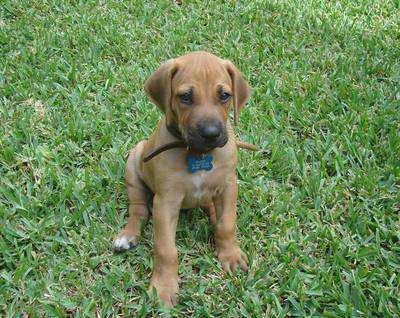

In [237]:
# Display the first few pictures
ims = [] # list of image paths
PATH_TEST = '/root/notebooks/data_small/dog-breed-identification/test'
for id in results_df[:8]['id']:
    print(id)
    ims.append(os.path.join(PATH_TEST, id+'.jpg'))
PIL.Image.open(ims[5])

In [224]:
data.test_dl.dataset.fnames[:8]

['test/d3a6dfa90bcc310da2dbb1d9e48adfae.jpg',
 'test/e757a7450559dc61a9261fe978e23b04.jpg',
 'test/cb7c8ef5b03d79feb9cf5416836ccc2d.jpg',
 'test/5028d2d148171673158c6ec80c03d8e7.jpg',
 'test/df01edf92d38b334f78bd85460304801.jpg',
 'test/b8e359b8f2e0a27d53611f3dd29c0b0b.jpg',
 'test/7a188995129759b9ffaa05b5599056aa.jpg',
 'test/21d9948fcea23bcade1344614a2bd8ae.jpg']